In [1]:
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.3 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x8

In [2]:
import torch # version 2.1.2
from torchvision import transforms # version 0.16.2
from PIL import Image
import io
import os
import glob
import argparse
import re
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer, set_seed # version 4.38.2
import requests
import json
from packaging import version
import PIL # version 10.2.0
from tqdm import tqdm

QUALITY = 25
TOTAL_PATCH_ROWS = 32 # how many [FFD0-FFD7] rows are there? for 256x256 resolution, 4:2:0 color -- (256 image side length / 16 patch side length / 8 restart markers) * (256 image side length / 16 patch side length) = 32
MAX_MODEL_SEQ_LEN = 12288
CACHE_TABLES_FN = "cache_tables.jpg"
UNICODE_OFFSET = 10240


def convert_img_to_bytes(img, quality=25, save_tables_file=False):
    def ConvertToJpeg(im, quality):
        with io.BytesIO() as f: # get jpeg bytes without fixed file headers -- streamtype=2
            im.save(f, format='JPEG', quality=quality, subsampling="4:2:0", streamtype=2, restart_marker_blocks=1)
            return f.getvalue()
    hexdata = ConvertToJpeg(img, quality).hex()
    int_list = [int(_e) for _e in bytearray.fromhex(hexdata)]
    str_list = ''.join([chr(_e + UNICODE_OFFSET) for _e in int_list]) # use braille characters to represent bytes -- UNICODE_OFFSET=10240
    if save_tables_file: # save jpeg headers (fixed tables for quantization and entropy coding) -- streamtype=1
        img.save(CACHE_TABLES_FN, quality=quality, subsampling="4:2:0", streamtype=1, restart_marker_blocks=1)
    return str_list


def save_byte_image(byte_list, gen_img_fn):
    with open(CACHE_TABLES_FN, 'rb') as f:
        hexdata = f.read().hex()
        table_int_list = [int(_e) for _e in bytearray.fromhex(hexdata)]
        table_int_list = table_int_list[2:-2] # removing first 2 and last 2 bytes (FF D8 and FF D9)
    int_list = [ord(_e) - UNICODE_OFFSET for _e in byte_list]
    int_list = int_list[:2] + table_int_list + int_list[2:]
    new_hexdata = bytes(int_list)
    with open(gen_img_fn + '.jpg', 'wb') as f:
        f.write(new_hexdata)


def build_prompt(image_str, tokenizer, prefix_ratio=0.0):
    def trim_after_n_occurrences(input_string, substring, n):
        pattern = re.compile('(' + re.escape(substring) + '(?:.*?' + re.escape(substring) + '){' + str(n-1) + '})')
        match = pattern.search(input_string)
        return input_string[:match.end()] if match else input_string

    if prefix_ratio == 0.0:
        input_ids = [tokenizer.bos_token_id]
    elif prefix_ratio > 0:
        image_str = trim_after_n_occurrences(image_str, '\u28ff\u28d7', int(TOTAL_PATCH_ROWS * prefix_ratio)) # UNICODE_OFFSET = 10240
        input_ids = [tokenizer.bos_token_id] + [_e  for _e in tokenizer(image_str, add_special_tokens=False)['input_ids']]
    else:
        raise ValueError(f"invalid prefix ratio")
    return input_ids


def clean_image_string(output_image_str): # UNICODE_OFFSET = 10240
    matched_output_image_str = re.match('\u28ff\u28d8.*?\u28ff\u28d9', output_image_str)
    if matched_output_image_str:
        output_image_str = matched_output_image_str.group()
    else:
        if output_image_str[-2:] != '\u28ff\u28d9':
            output_image_str = output_image_str + '\u28ff\u28d9'
        if output_image_str[:2] != '\u28ff\u28d8':
            output_image_str = '\u28ff\u28d8' + output_image_str
    return output_image_str

In [96]:

output_dir = "./"
os.makedirs(output_dir, exist_ok=True)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device: ", device)

jpeg_model_name = "uwnlp/jpeg-lm-reimplementation"
set_seed(42)

tokenizer = AutoTokenizer.from_pretrained(jpeg_model_name, use_fast=False, add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

max_memory_mapping = {0: "10GB", "cpu": "100GB"}

config = AutoConfig.from_pretrained(jpeg_model_name)
config.use_cache = True # use_cache=False was used in training
model = AutoModelForCausalLM.from_pretrained(
    jpeg_model_name,
    config=config,
    ignore_mismatched_sizes=False,
    torch_dtype=torch.float16,
    attn_implementation="flash_attention_2",
    device_map='auto',
    max_memory=max_memory_mapping
)
print("model bala oomad")
model.eval()

device:  cuda


Process Process-auto_conversion:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/transformers/safetensors_conversion.py", line 84, in auto_conversion
    sha = get_conversion_pr_reference(api, pretrained_model_name_or_path, **cached_file_kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/safetensors_conversion.py", line 71, in get_conversion_pr_reference
    spawn_conversion(token, private, model_id)
  File "/usr/local/lib/python3.11/dist-packages/transformers/safetensors_conversion.py", line 53, in spawn_conversion
    start(sse_connection)
  File "/usr/local/lib/python3.11/dist-packages/transformers/safetensors_conversion.py"

KeyboardInterrupt: 

green


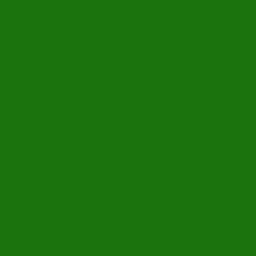

In [138]:
image_path = sorted(glob.glob('*.jpg'))
images = []

transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to 256x256
        # transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
        # transforms.ToTensor()
])

for _image_path in image_path:
    image = Image.open(_image_path).convert('RGB')
    obj = {
        'image':image,
        'caption': _image_path.split('.')[0],
    }
    images.append(obj) # transform here???

print(images[2]['caption'])
transform(images[2]['image'])

In [139]:
PREFIX_LEN = 52

w = images[2]['image']
image_strw = convert_img_to_bytes(w, quality=QUALITY, save_tables_file=True)
partial_input_idsw = build_prompt(image_strw, tokenizer, prefix_ratio=1)
partial_input_stringw = tokenizer.decode(partial_input_idsw, skip_special_tokens=True).strip()
partial_input_ids_tensorw = torch.tensor(partial_input_idsw, dtype=torch.long).to(device)

prefix = partial_input_idsw[0:PREFIX_LEN]
len(prefix)

52

In [140]:
type(partial_input_stringw)

str

In [141]:
image_str_list = [convert_img_to_bytes(obj['image'], quality=QUALITY, save_tables_file=False) for obj in images]

partial_input_ids_list = [build_prompt(obj, tokenizer, prefix_ratio=1) for obj in image_str_list]

partial_input_string_list = [tokenizer.decode(obj, skip_special_tokens=True).strip()  for obj in partial_input_ids_list]

# print(partial_input_string_list[0])
partial_input_ids_tensor_list  = []

for obj in partial_input_ids_list:

  partial_input_ids_tensor_list.append(torch.tensor(obj, dtype=torch.long).to(device))



In [142]:


embeddings_list = []
for obj in partial_input_ids_tensor_list:

  embedding = None
  with torch.no_grad():
      embeddings = model.model.embed_tokens(obj)
      embedding = torch.sum(embeddings, dim=0)
  embeddings_list.append(embedding)



In [143]:

for i,img in enumerate(images):
  text = img['caption']
  torch.save(embeddings_list[i], f"{text}.pt")

In [144]:
!zip -r files.zip *

  adding: blue.jpg (deflated 33%)
  adding: blue.pt (deflated 12%)
  adding: brown.jpg (deflated 33%)
  adding: brown.pt (deflated 12%)
  adding: cache_tables.jpg (deflated 32%)
  adding: green.jpg (deflated 33%)
  adding: green.pt (deflated 12%)
  adding: grey.jpg (deflated 33%)
  adding: grey.pt (deflated 12%)
  adding: lavender.jpg (deflated 33%)
  adding: lavender.pt (deflated 13%)
  adding: light grey.jpg (deflated 33%)
  adding: light grey.pt (deflated 13%)
  adding: lime.jpg (deflated 33%)
  adding: lime.pt (deflated 12%)
  adding: orange.jpg (deflated 33%)
  adding: orange.pt (deflated 12%)
  adding: pink.jpg (deflated 33%)
  adding: pink.pt (deflated 12%)
  adding: red.jpg (deflated 33%)
  adding: red.pt (deflated 12%)


In [145]:
def find_next_two(az, end, before, index):

    min_value = 1000000000
    best = [0, 0]
    for i in tqdm(range(0, 320)):
        for j in range(0, 320):
            # if i == 0 and j == 0:
            #     print('last is',partial_input_idsg[az +2:end])
            input_model = prefix + before + [i] + [j]
            input_model += partial_input_ids_list[index][az + 2:end]
            # input_model += [0] * (end - az -2)
            input_tensor = torch.tensor(input_model).to(dtype=torch.long, device=device)
            input_embeddings = model.model.embed_tokens(input_tensor)

            input_embedding = torch.sum(input_embeddings, dim=0)
            current_loss = torch.norm(embeddings_list[index] - input_embedding).item()
            if current_loss <= min_value:
                best = [i] + [j]
                min_value = current_loss
    if best[0] == 218:
      best[0], best[1] = best[1], best[0]

    return best

In [146]:
generated_sequences = []
for index, image_obj in enumerate(images):
    # if image_obj['caption'] not in ['pink','purple','light grey']:
    #   continue
    print(index)
    ans = []

    l = len(partial_input_ids_tensor_list[index])
    for i in range((l-PREFIX_LEN)//2):
        ans += find_next_two(52 + i*2, l, ans, index)

    ans = prefix + ans
    if l %2 == 1:
        ans.append(218)
    generated_sequences.append(ans)


0


100%|██████████| 320/320 [00:23<00:00, 13.37it/s]


1


100%|██████████| 320/320 [00:23<00:00, 13.61it/s]


2


100%|██████████| 320/320 [00:24<00:00, 13.28it/s]


3


100%|██████████| 320/320 [00:23<00:00, 13.40it/s]


4


100%|██████████| 320/320 [00:23<00:00, 13.69it/s]


5


100%|██████████| 320/320 [00:23<00:00, 13.38it/s]


6


100%|██████████| 320/320 [00:24<00:00, 13.26it/s]


7


100%|██████████| 320/320 [00:23<00:00, 13.37it/s]


8


100%|██████████| 320/320 [00:23<00:00, 13.38it/s]


9


100%|██████████| 320/320 [00:23<00:00, 13.37it/s]


In [148]:
for i in range(len(generated_sequences)):
    print('real', partial_input_ids_tensor_list[i][PREFIX_LEN:], 'generated',generated_sequences[i][PREFIX_LEN:])
# generated_sequences

real tensor([ 94,  37, 240,  99, 229,   9, 218], device='cuda:0') generated [94, 37, 240, 99, 229, 9, 218]
real tensor([264,  83, 117, 236, 201,  86,  64, 218], device='cuda:0') generated [264, 83, 236, 117, 201, 86, 64, 218]
real tensor([ 84,  37, 240, 138, 151,   9, 218], device='cuda:0') generated [84, 37, 240, 138, 151, 9, 218]
real tensor([ 68,   6, 218], device='cuda:0') generated [68, 6, 218]
real tensor([ 70,   3, 169, 132,   8, 218], device='cuda:0') generated [70, 3, 169, 132, 8, 218]
real tensor([ 77,  20,  64, 218], device='cuda:0') generated [77, 20, 64, 218]
real tensor([ 74,   3, 169, 161, 157,  64, 218], device='cuda:0') generated [74, 3, 169, 161, 157, 64, 218]
real tensor([ 77,   3, 169,  91, 243,  89,  64, 218], device='cuda:0') generated [77, 3, 169, 91, 243, 89, 64, 218]
real tensor([191,  37, 137, 252,  91,  64, 218], device='cuda:0') generated [191, 37, 252, 137, 91, 64, 218]
real tensor([ 84,  37, 240,  90, 250,  81,  64, 218], device='cuda:0') generated [84, 37

blue
    generated


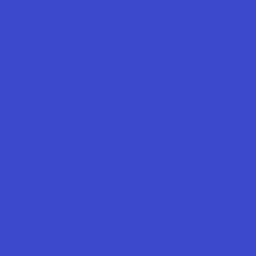

    real


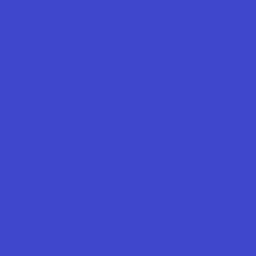



brown
    generated


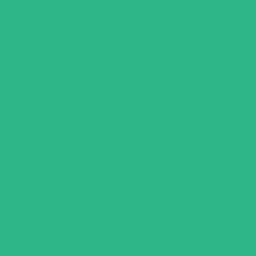

    real


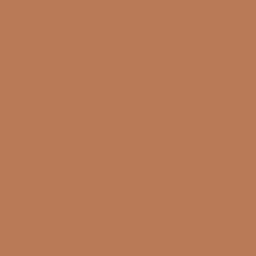



green
    generated


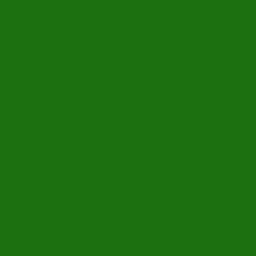

    real


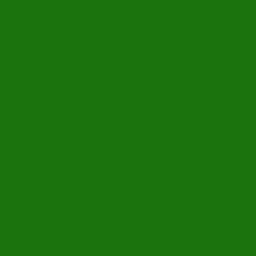



grey
    generated


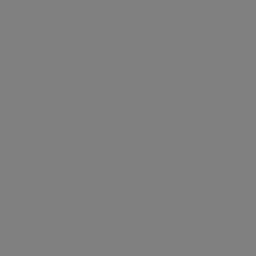

    real


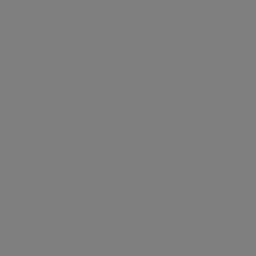



lavender
    generated


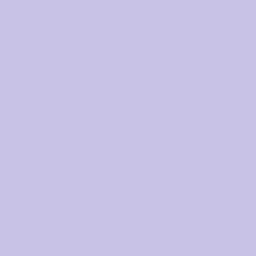

    real


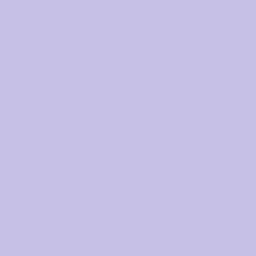



light grey
    generated


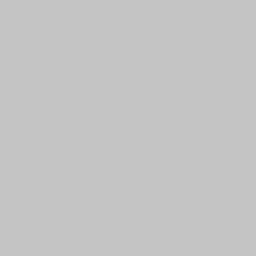

    real


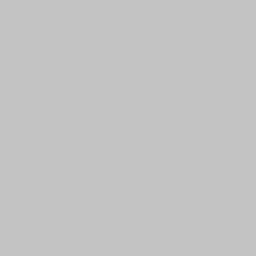



lime
    generated


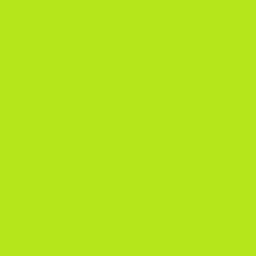

    real


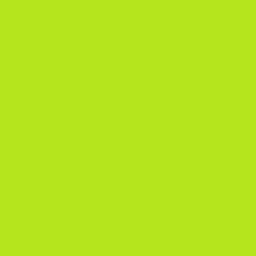



orange
    generated


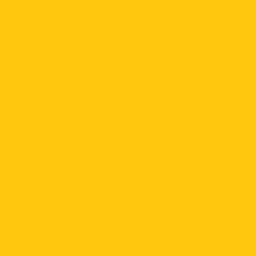

    real


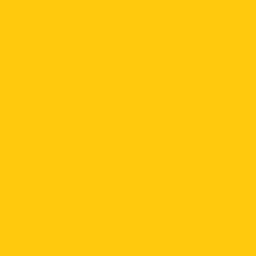



pink
    generated


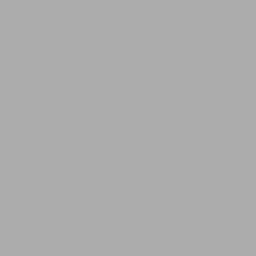

    real


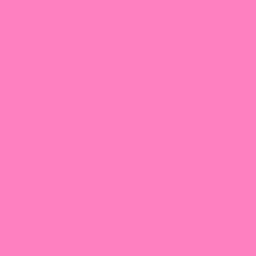



red
    generated


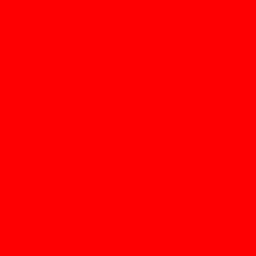

    real


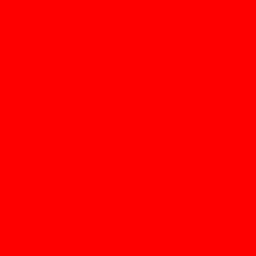

In [149]:
for index,seq in enumerate(generated_sequences):
    natije = tokenizer.decode(seq , skip_special_tokens=True).strip()
    save_byte_image(clean_image_string(natije), images[index]['caption']+'-gen')

    natije = Image.open(images[index]['caption'] + "-gen.jpg")
    try:
      natije = transform(natije)
    except:
      natije = None
    if natije == None:
      print('failed:',images[index]['caption'])
      continue
    print(images[index]['caption'])
    print('    generated')
    display(natije)
    print('    real')
    display(transform(images[index]['image']))
    print()
    print()


In [150]:
# now get the text embeddings from clip

In [152]:
def find_next_two_with_text(az, end, before, index):

    min_value = 1000000000
    best = [0, 0]
    for i in tqdm(range(0, 320)):
        for j in range(0, 320):
            # if i == 0 and j == 0:
            #     print('last is',partial_input_idsg[az +2:end])
            input_model = prefix + before + [i] + [j]
            input_model += partial_input_ids_list[index][az + 2:end]
            # input_model += [0] * (end - az -2)
            input_tensor = torch.tensor(input_model).to(dtype=torch.long, device=device)
            input_embeddings = model.model.embed_tokens(input_tensor)

            input_embedding = torch.sum(input_embeddings, dim=0)
            current_loss = torch.norm(text_embeddings_list[index] - input_embedding).item()
            if current_loss <= min_value:
                best = [i] + [j]
                min_value = current_loss
    if best[0] == 218:
      best[0], best[1] = best[1], best[0]
    print(min_value)
    return best

text_embeddings_list = []
for obj in images:
    t_emb = torch.load('t_' + obj['caption']+ '.pt')
    text_embeddings_list.append(t_emb)

text_embeddings_list

<ipython-input-152-ae5876ba4160>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_emb = torch.load('t_' + obj['caption']+ '.pt')


[tensor([-0.1802,  0.1803,  0.1135,  ..., -0.0349, -0.0865, -0.2721]),
 tensor([-0.1812,  0.1842,  0.1138,  ..., -0.0359, -0.0871, -0.2735]),
 tensor([-0.1813,  0.1826,  0.1125,  ..., -0.0345, -0.0872, -0.2724]),
 tensor([-0.1796,  0.1829,  0.1127,  ..., -0.0354, -0.0864, -0.2707]),
 tensor([-0.1717,  0.1836,  0.1011,  ..., -0.0333, -0.0833, -0.2528]),
 tensor([-0.1696,  0.1649,  0.1289,  ..., -0.0531, -0.0700, -0.2685]),
 tensor([-0.1710,  0.1838,  0.0986,  ..., -0.0328, -0.0829, -0.2499]),
 tensor([-0.1774,  0.1834,  0.1080,  ..., -0.0341, -0.0856, -0.2646]),
 tensor([-0.1952,  0.1778,  0.1197,  ..., -0.0337, -0.0880, -0.2847]),
 tensor([-0.1810,  0.1822,  0.1131,  ..., -0.0350, -0.0867, -0.2723])]

In [153]:
generated_sequences_with_text = []
for index, image_obj in enumerate(images):
    # if image_obj['caption'] not in ['pink','purple','light grey']:
    #   continue
    print(index)
    ans = []

    l = len(partial_input_ids_tensor_list[index])
    for i in range((l-PREFIX_LEN)//2):
        ans += find_next_two(52 + i*2, l, ans, index)

    ans = prefix + ans
    if l %2 == 1:
        ans.append(218)
    generated_sequences_with_text.append(ans)


0


100%|██████████| 320/320 [00:23<00:00, 13.45it/s]


1


100%|██████████| 320/320 [00:23<00:00, 13.51it/s]


2


100%|██████████| 320/320 [00:23<00:00, 13.40it/s]


3


100%|██████████| 320/320 [00:23<00:00, 13.47it/s]


4


100%|██████████| 320/320 [00:23<00:00, 13.58it/s]


5


100%|██████████| 320/320 [00:23<00:00, 13.62it/s]


6


100%|██████████| 320/320 [00:24<00:00, 13.33it/s]


7


100%|██████████| 320/320 [00:23<00:00, 13.41it/s]


8


100%|██████████| 320/320 [00:23<00:00, 13.40it/s]


9


100%|██████████| 320/320 [00:23<00:00, 13.56it/s]


blue
    generated


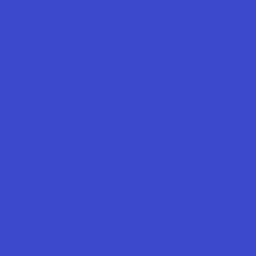

    real


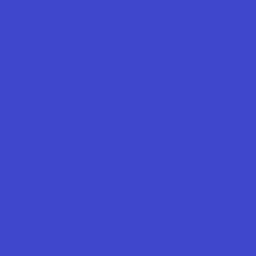



brown
    generated


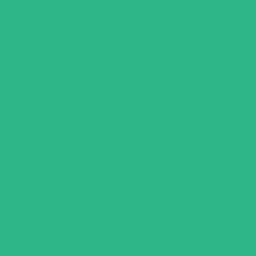

    real


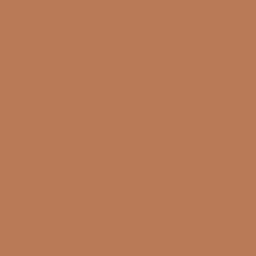



green
    generated


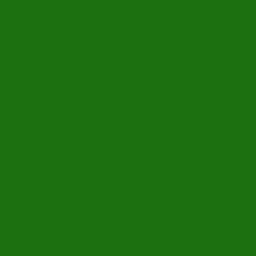

    real


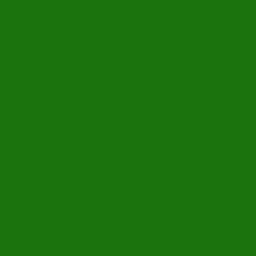



grey
    generated


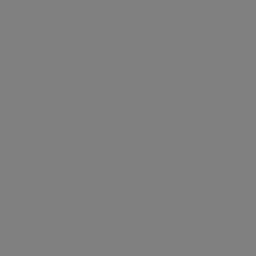

    real


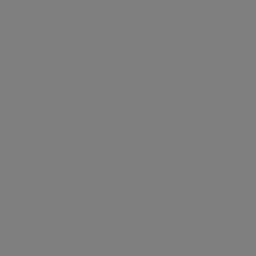



lavender
    generated


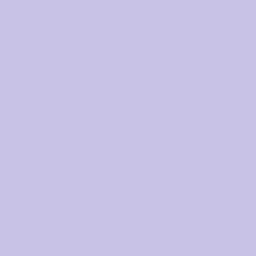

    real


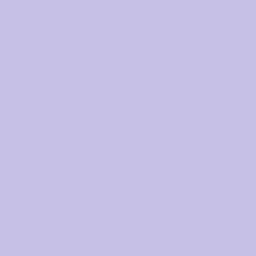



light grey
    generated


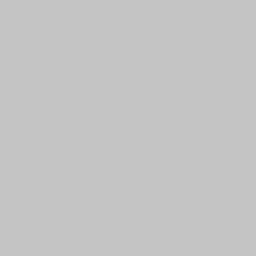

    real


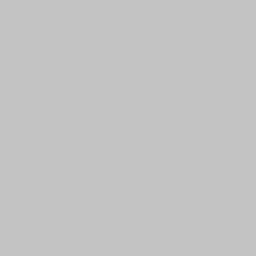



lime
    generated


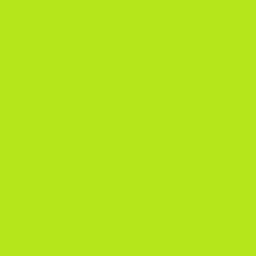

    real


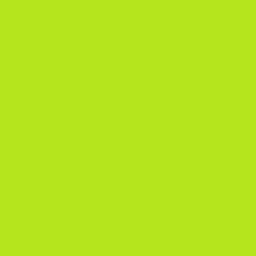



orange
    generated


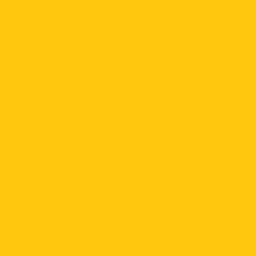

    real


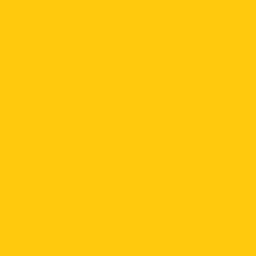



pink
    generated


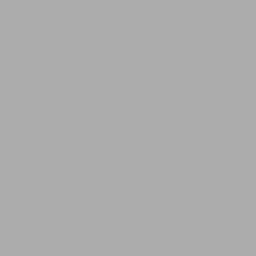

    real


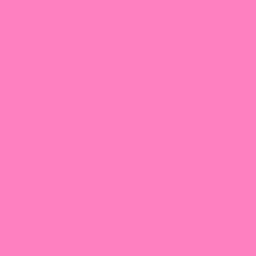



red
    generated


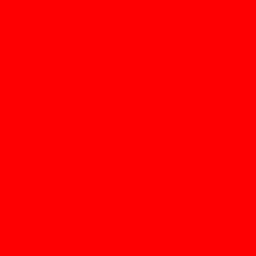

    real


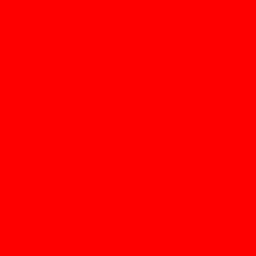

In [155]:
for index,seq in enumerate(generated_sequences_with_text):
    natije = tokenizer.decode(seq , skip_special_tokens=True).strip()
    save_byte_image(clean_image_string(natije), images[index]['caption']+'-gen-with-text')

    natije = Image.open(images[index]['caption'] + "-gen-with-text.jpg")
    try:
      natije = transform(natije)
    except:
      natije = None
    if natije == None:
      print('failed:',images[index]['caption'])
      continue
    print(images[index]['caption'])
    print('    generated')
    display(natije)
    print('    real')
    display(transform(images[index]['image']))
    print()
    print()


In [156]:
!zip -r files.zip *

updating: blue.jpg (deflated 33%)
updating: blue.pt (deflated 12%)
updating: brown.jpg (deflated 33%)
updating: brown.pt (deflated 12%)
updating: cache_tables.jpg (deflated 32%)
updating: green.jpg (deflated 33%)
updating: green.pt (deflated 12%)
updating: grey.jpg (deflated 33%)
updating: grey.pt (deflated 12%)
updating: lavender.jpg (deflated 33%)
updating: lavender.pt (deflated 13%)
updating: light grey.jpg (deflated 33%)
updating: light grey.pt (deflated 13%)
updating: lime.jpg (deflated 33%)
updating: lime.pt (deflated 12%)
updating: orange.jpg (deflated 33%)
updating: orange.pt (deflated 12%)
updating: pink.jpg (deflated 33%)
updating: pink.pt (deflated 12%)
updating: red.jpg (deflated 33%)
updating: red.pt (deflated 12%)
  adding: blue-gen.jpg (deflated 29%)
  adding: blue-gen-with-text.jpg (deflated 29%)
  adding: brown-gen.jpg (deflated 30%)
  adding: brown-gen-with-text.jpg (deflated 30%)
  adding: green-gen.jpg (deflated 29%)
  adding: green-gen-with-text.jpg (deflated 29%)


In [137]:
!rm ./*